In [1]:
import numpy as np
from numba import njit, prange
import csv
import os
import pandas as pd
from glob import glob
import time
import matplotlib.pyplot as plt
from src import functions as fcts
import scipy.stats as sc
import shutil
from sklearn.cluster import DBSCAN
from skimage.feature import peak_local_max
import sys
print(sys.executable)

/Users/isabellegarnreiter/opt/anaconda3/envs/vesicleSTORM/bin/python


In [2]:
# Import all files (cell zones) under one experiment type, but for both dep and spon vesicle targets
# Imported file names are printed

target_marker = 'PSD680'
access = 'computer'

if access == 'computer':
    target_directory = '/users/isabellegarnreiter/documents/vesicleSTORM/data/STORM_csv_files/'
    list_of_files = np.array([file for file in glob(target_directory + f'*/*{target_marker}*')])

elif access == 'drive':
    target_directory = '/Volumes/STORM_Nathalie/STORM DeMixing/'
    list_of_files = np.array([file for file in glob(target_directory + f'*{target_marker}*/*/*emix/*w*.csv')])
    

try:
    list_of_files = list_of_files.reshape(list_of_files.shape[0]//2,2)
except ValueError:
    print('Value Error: one channel is missing from one of the cellzones.')

zone_nb = list_of_files.shape[0]


#file info for experiments covered in the excel sheet 

usable_exp = pd.read_csv('/users/isabellegarnreiter/documents/vesicleSTORM/data/STORM_binary_list.csv',encoding='latin', sep=',').to_numpy()
filename  = usable_exp[:,0]+'_'+usable_exp[:,1]
files_infos = dict(zip(filename, usable_exp[:,2:]))


print("shape", list_of_files.shape)

shape (54, 2)


210430 SPON647_PSD680 10DIV_CellZone6


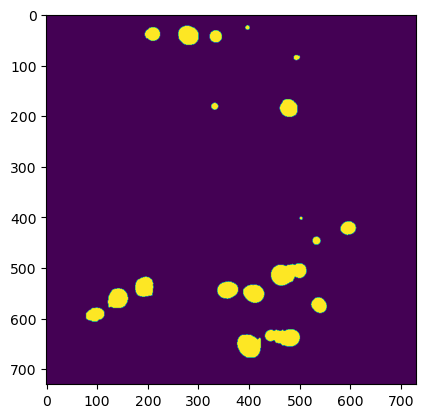

[152.11388461  68.02739726  68.02739726  68.02739726  68.02739726
  68.02739726  68.02739726  68.02739726  68.02739726  68.02739726
  68.02739726  68.02739726  68.02739726  68.02739726  68.02739726
  68.02739726  68.02739726  68.02739726  68.02739726  68.02739726
  68.02739726  68.02739726  68.02739726  68.02739726  68.02739726
  68.02739726  68.02739726  68.02739726  68.02739726  68.02739726
  68.02739726 280.48414434  68.02739726  68.02739726 136.05479452
  68.02739726  68.02739726  68.02739726  68.02739726  96.20526782
  68.02739726  68.02739726  68.02739726  96.20526782  68.02739726
  68.02739726  68.02739726  68.02739726  68.02739726 680.2739726
  68.02739726  68.02739726  68.02739726  68.02739726  68.02739726
  68.02739726  68.02739726  68.02739726  68.02739726  68.02739726
  68.02739726  68.02739726  68.02739726  68.02739726  68.02739726
  68.02739726  68.02739726  68.02739726  68.02739726  68.02739726
  68.02739726  68.02739726  68.02739726  68.02739726  68.02739726
  68.027397

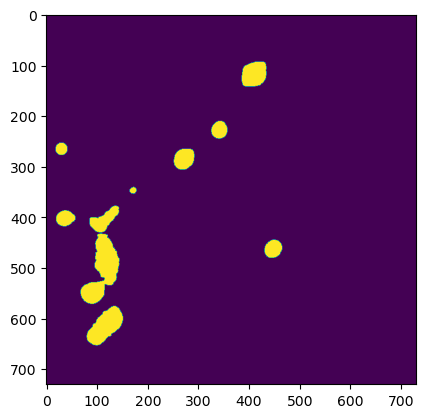

[ 68.02739726  68.02739726  68.02739726  68.02739726  68.02739726
  96.20526782  68.02739726  68.02739726  68.02739726  68.02739726
  68.02739726  68.02739726  68.02739726  68.02739726  68.02739726
  68.02739726  68.02739726  68.02739726  68.02739726  68.02739726
  68.02739726  68.02739726  68.02739726  68.02739726  68.02739726
  68.02739726  68.02739726  68.02739726  68.02739726  68.02739726
  68.02739726  68.02739726  68.02739726  68.02739726  68.02739726
  68.02739726  68.02739726  68.02739726  68.02739726  68.02739726
  68.02739726  68.02739726  68.02739726  68.02739726  68.02739726
  68.02739726  68.02739726  68.02739726  68.02739726  68.02739726
  68.02739726 192.41053564  68.02739726  68.02739726  68.02739726
  68.02739726 192.41053564  68.02739726  68.02739726  68.02739726
  68.02739726  68.02739726  68.02739726  68.02739726  68.02739726
  68.02739726  68.02739726  68.02739726  68.02739726  68.02739726
  68.02739726  68.02739726  68.02739726  68.02739726  68.02739726
  68.02739

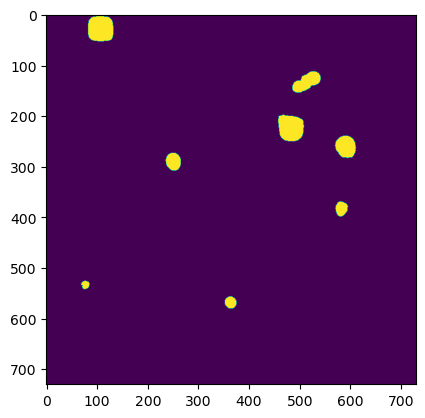

[ 96.20526782  68.02739726  68.02739726 152.11388461  96.20526782
  68.02739726  96.20526782  68.02739726  96.20526782  96.20526782
  68.02739726  96.20526782  68.02739726  68.02739726  68.02739726
  68.02739726  96.20526782  96.20526782  96.20526782  68.02739726
  68.02739726  68.02739726  68.02739726  68.02739726  68.02739726
  68.02739726  68.02739726  68.02739726  68.02739726  68.02739726
  68.02739726  68.02739726  68.02739726  68.02739726  68.02739726
  68.02739726  68.02739726  68.02739726  68.02739726  68.02739726
  68.02739726  68.02739726  68.02739726  68.02739726  68.02739726
  68.02739726  68.02739726  68.02739726  68.02739726  68.02739726
  68.02739726  68.02739726  68.02739726  68.02739726  68.02739726
  68.02739726  68.02739726  68.02739726  68.02739726  68.02739726
  68.02739726  68.02739726  68.02739726  68.02739726  68.02739726
  68.02739726  68.02739726  68.02739726  68.02739726  68.02739726
  68.02739726  68.02739726  68.02739726  68.02739726  68.02739726
  68.02739

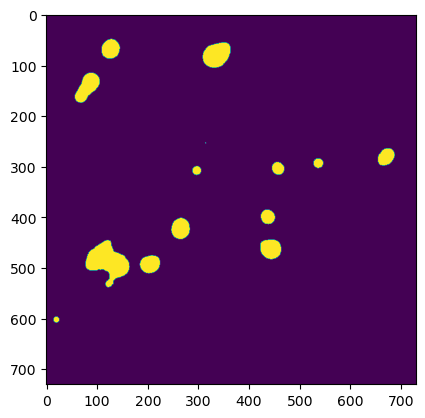

[68.02739726 68.02739726 68.02739726 ... 68.02739726 68.02739726
 68.02739726]
210401 DEP647_PSD680 10DIV_CellZone0


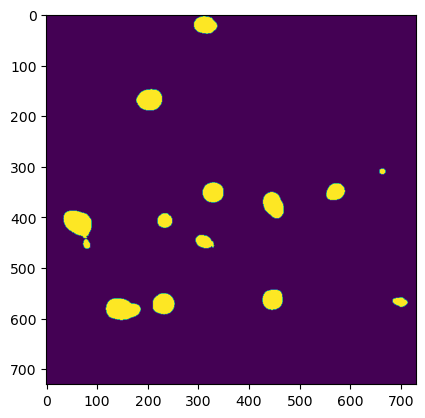

[192.41053564 152.11388461  68.02739726 ...  68.02739726  68.02739726
 581.22633698]
210212 DEP647_PSD680 8DIV_CellZone7


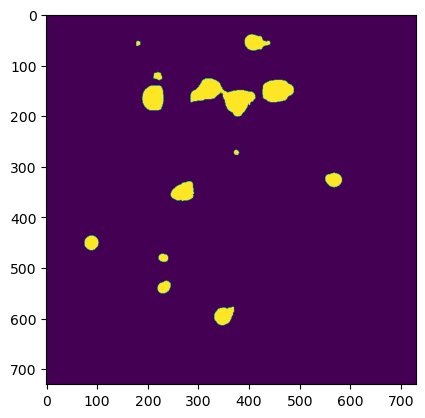

[ 68.02739726  68.02739726  68.02739726 ...  68.02739726  68.02739726
 581.22633698]
210414 DEP647_PSD680 8DIV_CellZone1
210209 SPON647_PSD680 8DIV_CellZone3


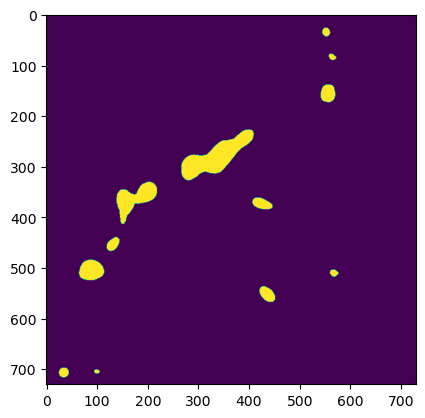

[68.02739726 68.02739726 68.02739726 ... 68.02739726 68.02739726
 68.02739726]
210208 DEP647_PSD680 8DIV_CellZone1


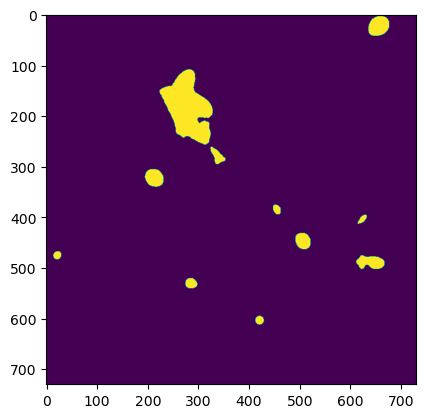

[68.02739726 68.02739726 68.02739726 ... 68.02739726 68.02739726
 68.02739726]
210209 SPON647_PSD680 8DIV_CellZone5


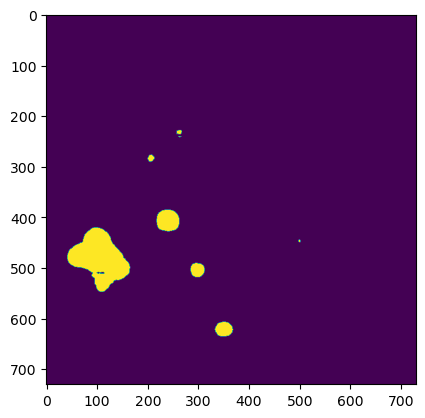

[136.05479452  68.02739726 215.12151864 ...  68.02739726  68.02739726
  68.02739726]
210209 SPON647_PSD680 8DIV_CellZone1


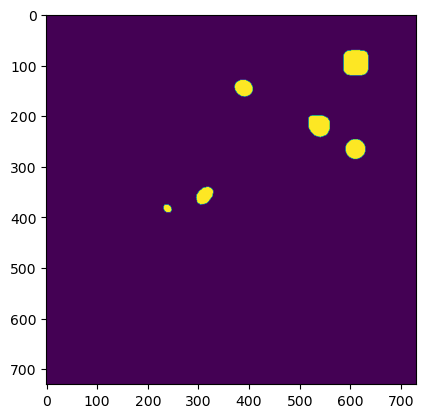

[152.11388461  68.02739726  96.20526782  68.02739726  68.02739726
  68.02739726  68.02739726  68.02739726  68.02739726  68.02739726
  68.02739726  68.02739726  68.02739726  68.02739726  68.02739726
 272.10958904  68.02739726  68.02739726  68.02739726 304.22776921
  68.02739726  68.02739726 272.10958904  68.02739726  68.02739726
  68.02739726  68.02739726  68.02739726 272.10958904  68.02739726
  68.02739726  68.02739726  68.02739726  68.02739726  68.02739726
  68.02739726  68.02739726  68.02739726  68.02739726  68.02739726
  68.02739726  68.02739726  68.02739726  68.02739726  68.02739726
  68.02739726  68.02739726  68.02739726  68.02739726  68.02739726
  68.02739726  68.02739726  68.02739726  68.02739726  68.02739726
  68.02739726  68.02739726  68.02739726  68.02739726  68.02739726
  68.02739726  68.02739726  68.02739726 136.05479452  68.02739726
  68.02739726 152.11388461  68.02739726  68.02739726  68.02739726
 136.05479452 136.05479452  68.02739726  68.02739726  68.02739726
  68.02739

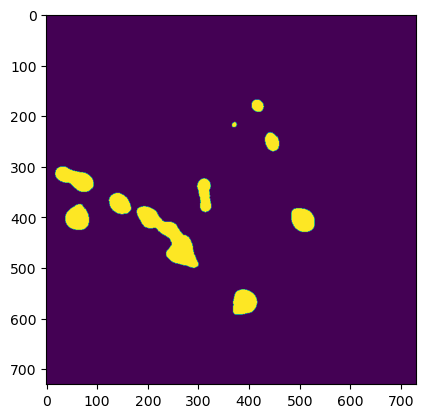

[96.20526782 68.02739726 68.02739726 ... 68.02739726 68.02739726
 68.02739726]
210212 DEP647_PSD680 8DIV_CellZone5


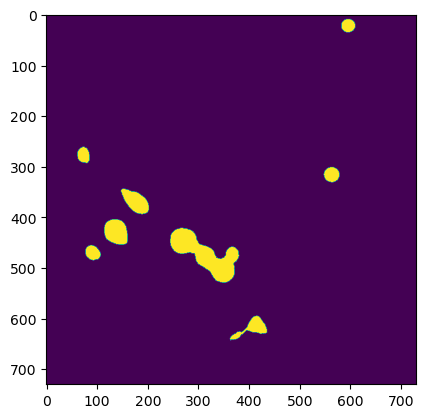

[68.02739726 68.02739726 68.02739726 ... 68.02739726 68.02739726
 68.02739726]
210426 DEP647_PSD680 10DIV_CellZone6


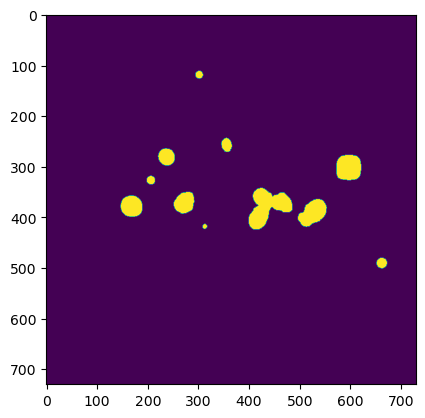

[68.02739726 68.02739726 68.02739726 ... 68.02739726 68.02739726
 68.02739726]
210430 SPON647_PSD680 10DIV_CellZone10


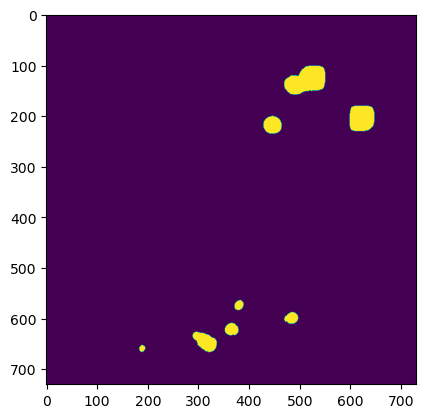

[ 68.02739726  68.02739726  68.02739726  68.02739726  68.02739726
  68.02739726  68.02739726  68.02739726  68.02739726  68.02739726
  68.02739726  68.02739726  68.02739726  68.02739726  68.02739726
  68.02739726  68.02739726  68.02739726  68.02739726  68.02739726
  68.02739726  68.02739726 152.11388461  68.02739726  68.02739726
  68.02739726  68.02739726  68.02739726  68.02739726  68.02739726
  68.02739726  68.02739726  68.02739726  68.02739726 245.27626896
  68.02739726  68.02739726  68.02739726  68.02739726  68.02739726
  68.02739726  68.02739726  68.02739726  68.02739726  68.02739726
  68.02739726  68.02739726  68.02739726  68.02739726  68.02739726
  68.02739726  68.02739726  68.02739726  68.02739726  68.02739726
  68.02739726  68.02739726  68.02739726  68.02739726  68.02739726
  68.02739726  68.02739726  68.02739726  68.02739726  68.02739726
  68.02739726  68.02739726  68.02739726  68.02739726  68.02739726
  68.02739726  68.02739726  68.02739726  68.02739726  68.02739726
  68.02739

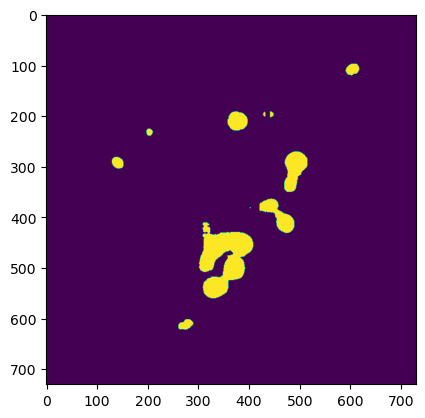

[68.02739726 68.02739726 68.02739726 ... 68.02739726 68.02739726
 68.02739726]
210414 DEP647_PSD680 8DIV_CellZone2


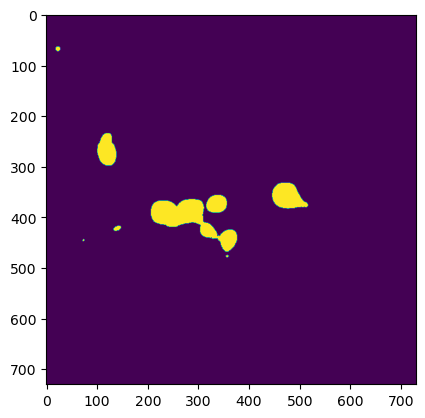

[68.02739726 68.02739726 68.02739726 ... 68.02739726 68.02739726
 68.02739726]
210212 DEP647_PSD680 8DIV_CellZone6


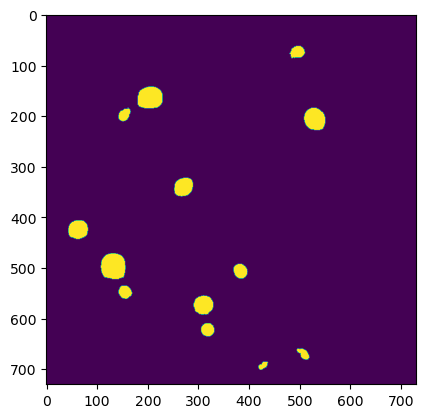

[68.02739726 68.02739726 68.02739726 ... 68.02739726 68.02739726
 68.02739726]
210208 DEP647_PSD680 8DIV_CellZone2


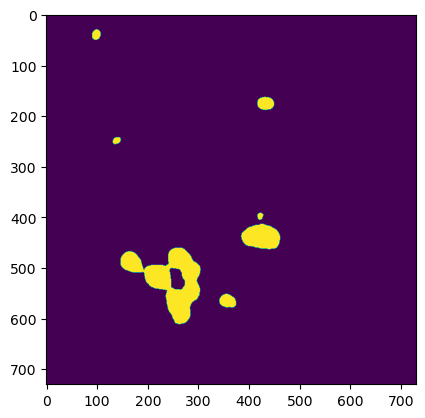

[ 68.02739726  68.02739726  68.02739726 ...  68.02739726 136.05479452
  68.02739726]
210209 SPON647_PSD680 8DIV_CellZone4


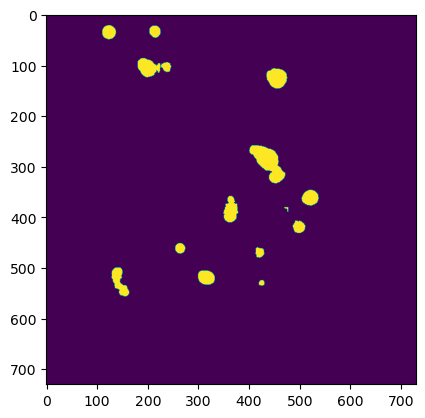

[68.02739726 68.02739726 68.02739726 ... 68.02739726 68.02739726
 68.02739726]
210212 DEP647_PSD680 8DIV_CellZone9


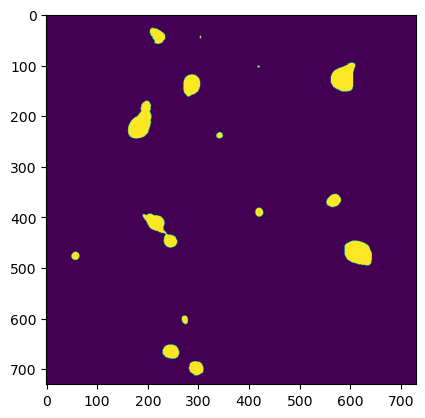

[68.02739726 68.02739726 68.02739726 ... 68.02739726 68.02739726
 96.20526782]
210414 DEP647_PSD680 8DIV_CellZone0


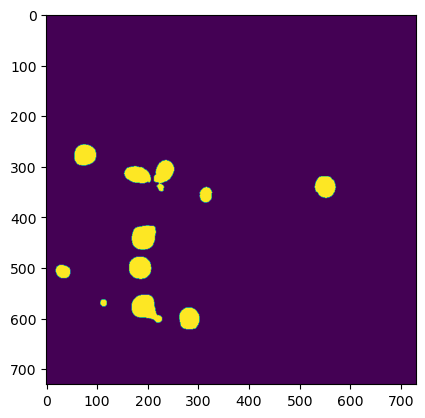

[68.02739726 68.02739726 68.02739726 ... 68.02739726 68.02739726
 68.02739726]
210209 SPON647_PSD680 8DIV_CellZone2


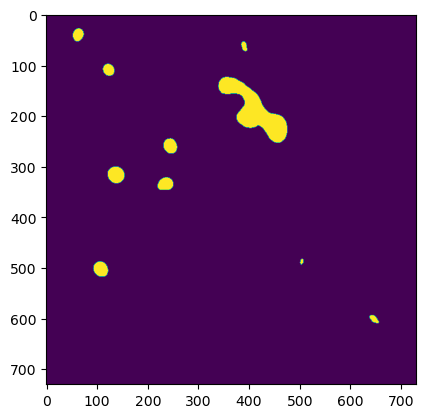

[68.02739726 68.02739726 68.02739726 ... 68.02739726 68.02739726
 68.02739726]
210401 DEP647_PSD680 10DIV_CellZone2
210430 SPON647_PSD680 10DIV_CellZone1


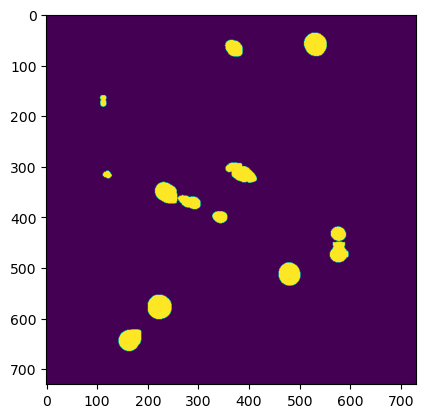

[  68.02739726   68.02739726   68.02739726   68.02739726   96.20526782
   68.02739726   68.02739726   68.02739726   68.02739726   68.02739726
   68.02739726   68.02739726   68.02739726   68.02739726   68.02739726
  288.61580346   68.02739726   68.02739726   68.02739726   68.02739726
   68.02739726   68.02739726   68.02739726   68.02739726   68.02739726
   68.02739726   68.02739726   68.02739726   68.02739726   68.02739726
   68.02739726   68.02739726   68.02739726   68.02739726   68.02739726
   68.02739726   68.02739726   68.02739726   68.02739726   68.02739726
   68.02739726   68.02739726   68.02739726   68.02739726   68.02739726
   68.02739726   68.02739726   68.02739726   68.02739726   68.02739726
   68.02739726   68.02739726   68.02739726   68.02739726   68.02739726
   68.02739726   68.02739726   68.02739726   68.02739726   68.02739726
   68.02739726   68.02739726   68.02739726   68.02739726   68.02739726
   68.02739726   68.02739726   68.02739726   68.02739726   68.02739726
   68.

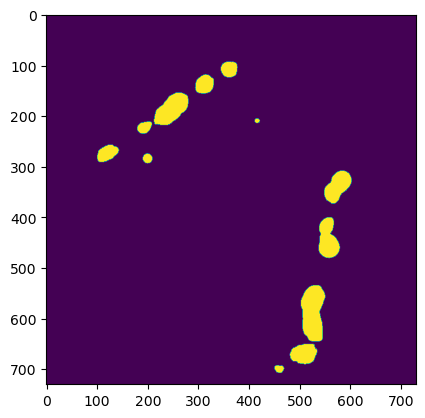

[68.02739726 68.02739726 68.02739726 ... 68.02739726 68.02739726
 68.02739726]
210426 DEP647_PSD680 10DIV_CellZone2


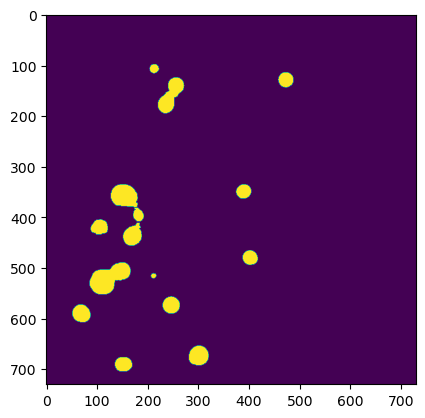

[136.05479452  68.02739726  68.02739726 ...  68.02739726  68.02739726
  68.02739726]
210414 SPON647_PSD680 8DIV_CellZone4


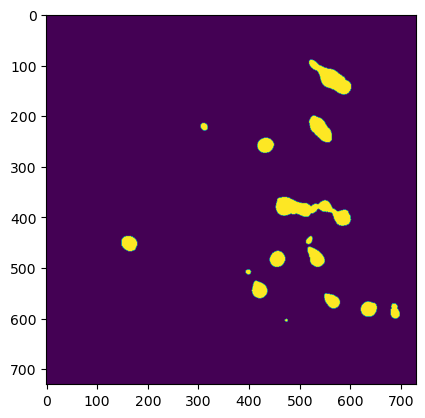

[68.02739726 68.02739726 68.02739726 ... 68.02739726 68.02739726
 68.02739726]
210414 DEP647_PSD680 8DIV_unnammed6


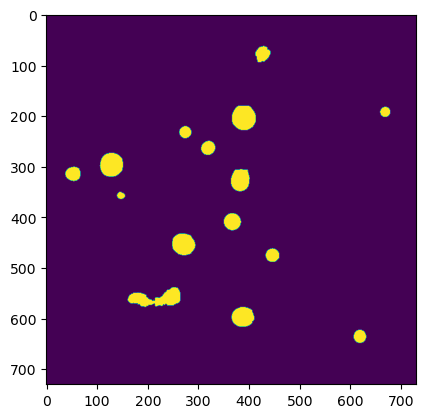

[ 136.05479452   68.02739726   68.02739726   68.02739726   68.02739726
   68.02739726   68.02739726   68.02739726   68.02739726   68.02739726
   68.02739726   68.02739726   96.20526782   68.02739726   96.20526782
   96.20526782   68.02739726   68.02739726   68.02739726   68.02739726
   68.02739726   68.02739726   68.02739726   68.02739726   68.02739726
   68.02739726   68.02739726   68.02739726   68.02739726   68.02739726
   68.02739726   68.02739726   68.02739726   68.02739726  476.19178082
   96.20526782   96.20526782  435.58787621  775.6316659    68.02739726
   68.02739726   68.02739726   68.02739726   68.02739726   68.02739726
   68.02739726   68.02739726   68.02739726   68.02739726   68.02739726
   68.02739726   68.02739726   68.02739726   68.02739726   68.02739726
   68.02739726   68.02739726   68.02739726   68.02739726   68.02739726
   68.02739726   68.02739726   68.02739726 1496.60273973   68.02739726
   68.02739726   68.02739726   68.02739726   68.02739726   68.02739726
   68.

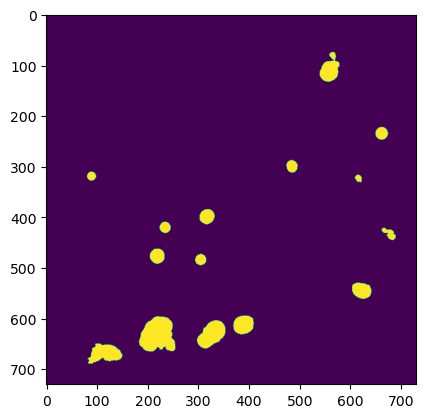

[ 68.02739726  68.02739726  68.02739726  68.02739726  68.02739726
  68.02739726  68.02739726  68.02739726  68.02739726  68.02739726
  68.02739726  68.02739726  68.02739726  68.02739726  68.02739726
  68.02739726  68.02739726  68.02739726  68.02739726  68.02739726
  68.02739726  68.02739726  68.02739726  68.02739726  68.02739726
  68.02739726  68.02739726  68.02739726 136.05479452  68.02739726
 280.48414434  96.20526782  68.02739726  68.02739726  68.02739726
  68.02739726  68.02739726  68.02739726  68.02739726  68.02739726
  68.02739726  68.02739726  68.02739726  68.02739726  68.02739726
  68.02739726  68.02739726  68.02739726  68.02739726  68.02739726
  68.02739726  68.02739726  68.02739726  68.02739726  68.02739726
  68.02739726  68.02739726  68.02739726  68.02739726  68.02739726
  68.02739726  68.02739726  68.02739726  68.02739726  68.02739726
  68.02739726  68.02739726  68.02739726  68.02739726  68.02739726
  68.02739726  68.02739726  68.02739726  68.02739726  68.02739726
  68.02739

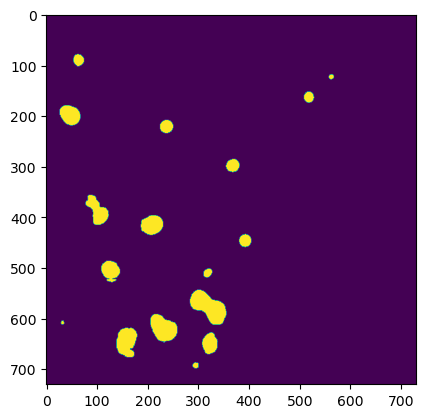

[68.02739726 68.02739726 68.02739726 ... 68.02739726 68.02739726
 68.02739726]
210426 DEP647_PSD680 10DIV_CellZone1


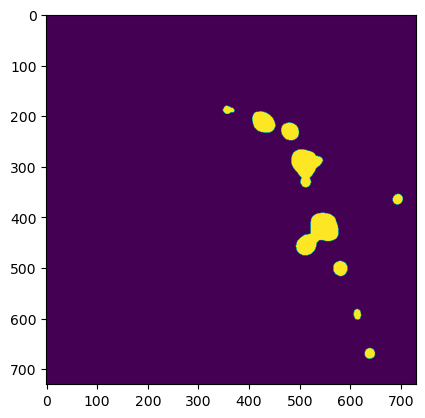

[68.02739726 68.02739726 68.02739726 ... 68.02739726 68.02739726
 68.02739726]
210426 DEP647_PSD680 10DIV_CellZone3


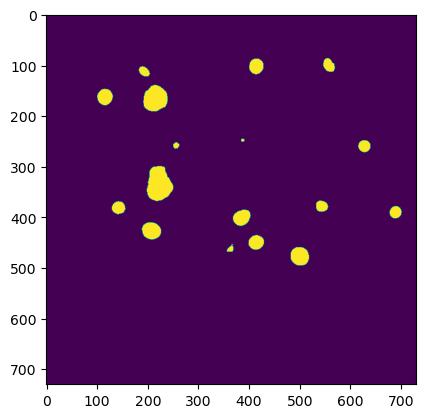

[68.02739726 68.02739726 68.02739726 ... 68.02739726 68.02739726
 68.02739726]
210430 SPON647_PSD680 10DIV_CellZone8


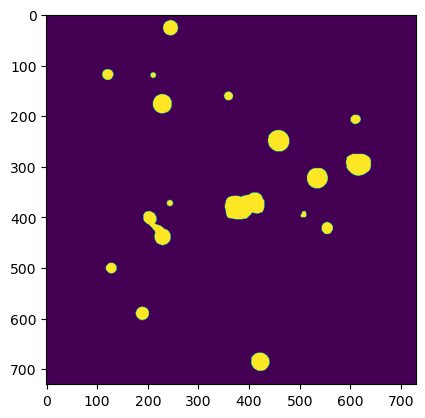

[ 68.02739726  68.02739726  68.02739726 ...  68.02739726  68.02739726
 152.11388461]
210430 SPON647_PSD680 10DIV_CellZone2


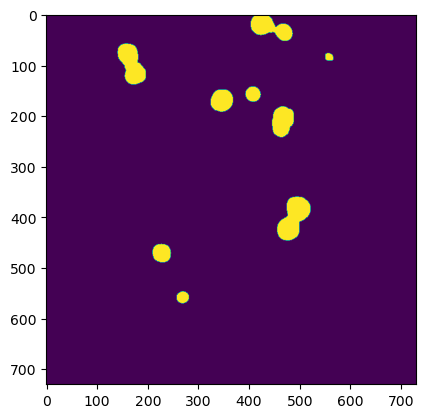

[68.02739726 68.02739726 68.02739726 ... 68.02739726 68.02739726
 68.02739726]
210426 DEP647_PSD680 10DIV_CellZone5


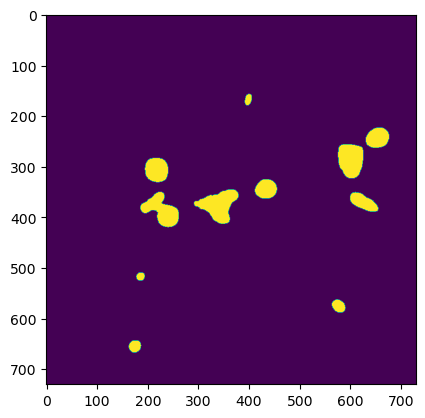

[68.02739726 68.02739726 68.02739726 ... 68.02739726 68.02739726
 68.02739726]
210430 SPON647_PSD680 10DIV_CellZone4


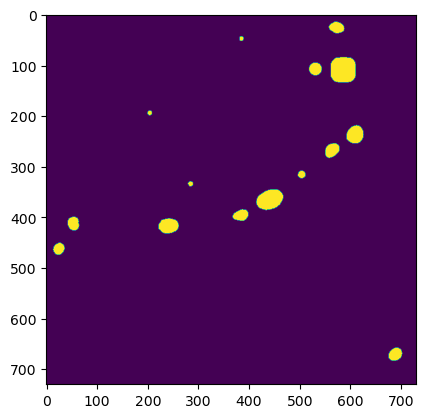

[245.27626896  96.20526782  68.02739726 ...  68.02739726 280.48414434
 192.41053564]
210404 SPON647_PSD680 10DIV_CellZone1


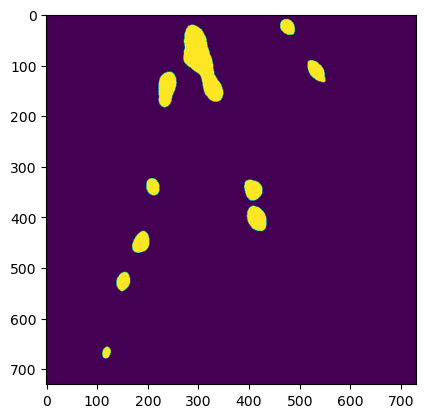

[68.02739726 96.20526782 68.02739726 ... 68.02739726 68.02739726
 68.02739726]
210404 SPON647_PSD680 10DIV_CellZone0


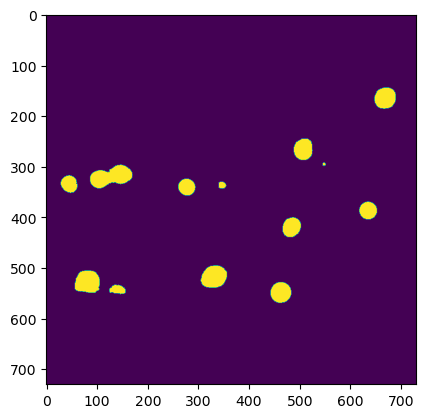

[ 68.02739726  68.02739726  68.02739726  68.02739726  68.02739726
  68.02739726  68.02739726  68.02739726  68.02739726  68.02739726
  68.02739726  68.02739726  68.02739726  68.02739726  68.02739726
  68.02739726  68.02739726  68.02739726  68.02739726  68.02739726
  68.02739726  68.02739726  68.02739726  68.02739726  68.02739726
  68.02739726  68.02739726  68.02739726  68.02739726  68.02739726
  68.02739726  68.02739726  68.02739726  68.02739726  68.02739726
  68.02739726  68.02739726  68.02739726  68.02739726  68.02739726
  96.20526782  68.02739726  68.02739726  68.02739726  68.02739726
  68.02739726  68.02739726  68.02739726  68.02739726  68.02739726
  68.02739726  68.02739726  68.02739726  68.02739726  68.02739726
  68.02739726  68.02739726  68.02739726  68.02739726  68.02739726
  68.02739726  68.02739726  68.02739726  68.02739726  68.02739726
  68.02739726  68.02739726  68.02739726  68.02739726  68.02739726
  68.02739726  68.02739726  68.02739726  68.02739726  68.02739726
  68.02739

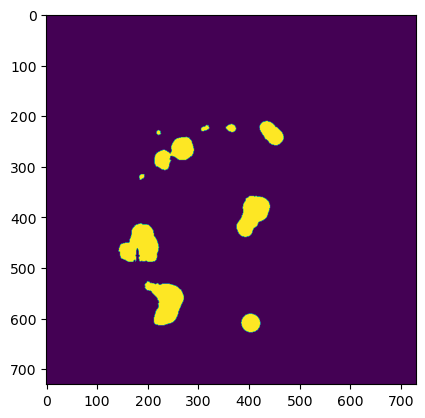

[68.02739726 68.02739726 68.02739726 ... 68.02739726 96.20526782
 68.02739726]
210212 DEP647_PSD680 8DIV_CellZone4
210208 DEP647_PSD680 8DIV_CellZone5


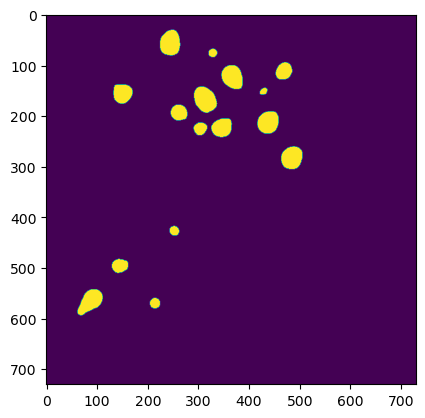

[215.12151864  96.20526782 204.08219178 ...  68.02739726  68.02739726
  68.02739726]
210209 SPON647_PSD680 8DIV_CellZone6


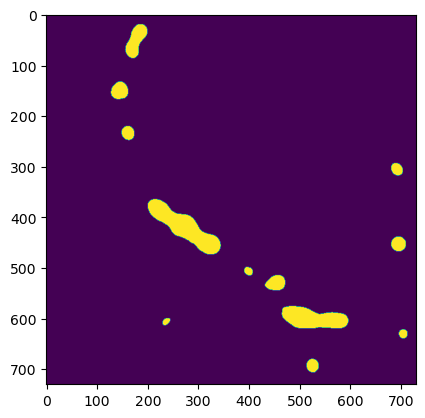

[68.02739726 68.02739726 68.02739726 ... 68.02739726 68.02739726
 68.02739726]
210430 SPON647_PSD680 10DIV_CellZone5


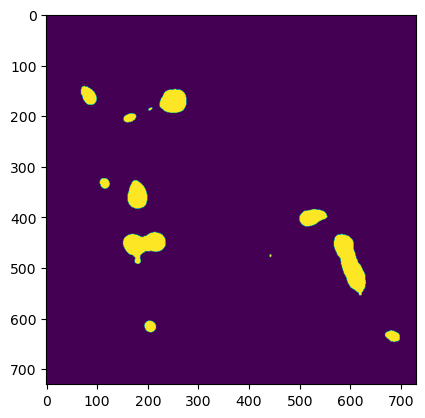

[68.02739726 68.02739726 68.02739726 ... 68.02739726 68.02739726
 68.02739726]
210426 DEP647_PSD680 10DIV_CellZone4


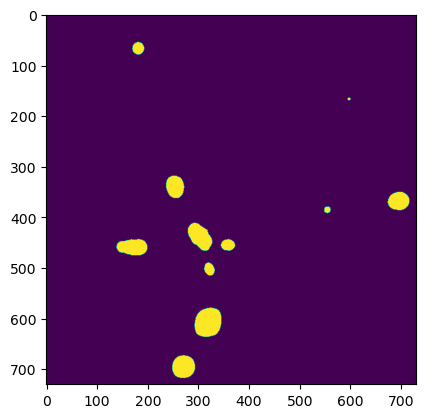

[68.02739726 68.02739726 68.02739726 ... 68.02739726 68.02739726
 68.02739726]
210430 SPON647_PSD680 10DIV_CellZone3


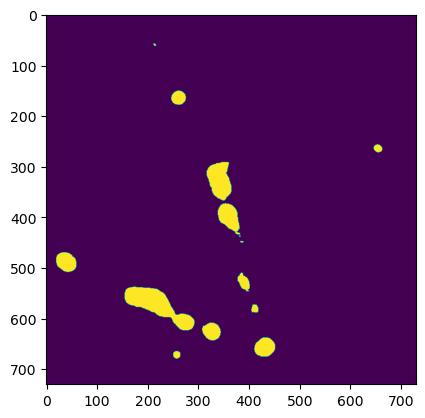

[68.02739726 68.02739726 68.02739726 ... 68.02739726 68.02739726
 68.02739726]
210208 DEP647_PSD680 8DIV_CellZone3
210209 SPON647_PSD680 8DIV_CellZone7
210208 DEP647_PSD680 8DIV_CellZone8


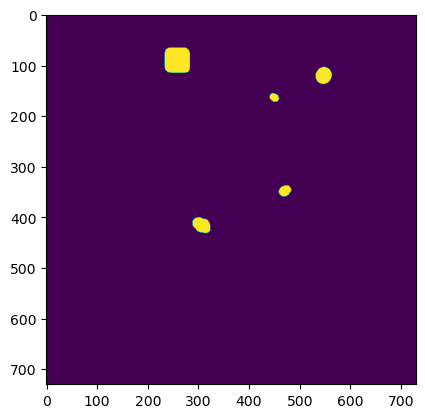

[ 68.02739726  68.02739726  68.02739726  68.02739726  68.02739726
  68.02739726  68.02739726  68.02739726  68.02739726  68.02739726
  68.02739726  68.02739726  68.02739726  68.02739726  68.02739726
  68.02739726  68.02739726  68.02739726  68.02739726  96.20526782
  68.02739726  68.02739726  68.02739726  68.02739726  68.02739726
  68.02739726  68.02739726  68.02739726  68.02739726  68.02739726
  68.02739726  68.02739726  68.02739726  68.02739726  68.02739726
  68.02739726  68.02739726  68.02739726  68.02739726  68.02739726
  68.02739726  68.02739726  68.02739726  68.02739726  68.02739726
  96.20526782  68.02739726  68.02739726  68.02739726  68.02739726
  68.02739726  68.02739726  96.20526782  68.02739726  68.02739726
  68.02739726  68.02739726  68.02739726  68.02739726  68.02739726
  68.02739726  68.02739726  68.02739726  68.02739726  68.02739726
 152.11388461  68.02739726  68.02739726  68.02739726  68.02739726
  68.02739726  68.02739726  68.02739726  68.02739726 152.11388461
  68.02739

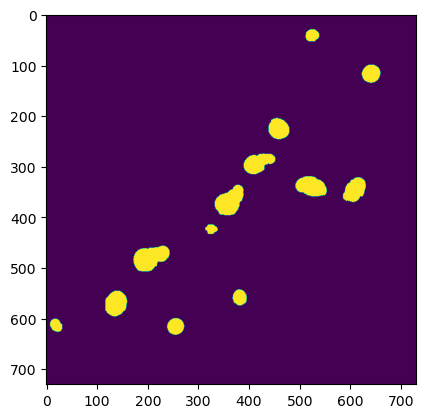

[ 68.02739726  68.02739726  68.02739726  68.02739726  68.02739726
  68.02739726  68.02739726  68.02739726  68.02739726  68.02739726
  68.02739726  68.02739726  68.02739726  68.02739726  68.02739726
  68.02739726  68.02739726  68.02739726  68.02739726  68.02739726
  68.02739726  68.02739726  68.02739726  68.02739726  68.02739726
  68.02739726  68.02739726  68.02739726  68.02739726  68.02739726
  68.02739726  68.02739726  68.02739726  68.02739726  68.02739726
  68.02739726  68.02739726  68.02739726  68.02739726  68.02739726
  68.02739726  68.02739726 456.34165382  68.02739726  68.02739726
  68.02739726  68.02739726  68.02739726  68.02739726  68.02739726
  68.02739726  68.02739726  68.02739726  68.02739726  68.02739726
  68.02739726  68.02739726  68.02739726  68.02739726  68.02739726
  68.02739726  68.02739726  68.02739726  68.02739726  68.02739726
  68.02739726  68.02739726  68.02739726  68.02739726  68.02739726
  68.02739726  68.02739726  68.02739726  68.02739726  68.02739726
  68.02739

In [3]:
#minimum distance for clusters of vesicles

image_size = (730,730,16)
kernel_size = (50,50,1)
sigma = 15

max_threshold_ves = 12
max_threshold_mark = 4
max_area = (21,21,21)

min_dist_marker = {}
min_dist_vesicle = {}
SNR_dict = {}
for file_name in list_of_files:
    
    if access == 'drive':
        new_file_name = f"{(file_name[0]).split('/')[4]}_{(file_name[0]).split('/')[5]}"
    
    elif access == 'computer':
        new_file_name = f"{(file_name[0]).split('/')[-1][0:-3]}"
    
    print(new_file_name)
    
    file_info = files_infos[new_file_name]
    
    
    if file_info[0] == 0:
        pass
    
    else:
        vesicles = pd.read_csv(file_name[file_info[1]])[['x [nm]', 'y [nm]', 'z [nm]']].to_numpy(dtype=np.float64)
        synapse_marker = pd.read_csv(file_name[(file_info[1]-1)**2])[['x [nm]', 'y [nm]', 'z [nm]']].to_numpy(dtype=np.float64)
        
        #plot the locations of both the vesicles and the synaptic marker using a large point spread function.
        wide_field_vesicles = fcts.get_wide_field(vesicles, image_size, kernel_size, sigma)
        wide_field_marker = fcts.get_wide_field(synapse_marker, image_size, kernel_size, sigma)
        
        #plot the locations of the vesicles using the same image size as above to a single pixel size
        image_vesicles = fcts.get_wide_field(vesicles, image_size, (1,1,1), sigma)
        
        #calculate the intensity threshold for the large PSF images, depending on an arbitrary intensity threshold, dependent on the mean and std of each image.
        ves_thresh = wide_field_vesicles.mean() + wide_field_vesicles.std() * max_threshold_ves
        marker_thresh = wide_field_marker.mean() + wide_field_marker.std() * max_threshold_mark
        
        #create a mask of the large PSF images where for the pixels above the threshold
        mask_vesicles = (wide_field_vesicles > ves_thresh) * 1

        plt.imshow(mask_vesicles[:,:,0])
        plt.show()
        mask_marker = (wide_field_marker > marker_thresh) * 1

        #create an array for the vesicles which are located within the mask
        masked_vesicles = np.where(mask_vesicles, image_vesicles, 0)
        vesicle_pos_tup = np.where(masked_vesicles > 0)
        vesicle_pos = np.array([vesicle_pos_tup[0],vesicle_pos_tup[1],vesicle_pos_tup[2]]).T
        vesicle_pos = vesicle_pos/image_size * 49660
        
        nb_vesicles_tot = vesicles.shape[0]
        nb_vesicles_selected = vesicle_pos.shape[0]
        snr = nb_vesicles_selected/nb_vesicles_tot
        
        #calculate the distance between vesicles within the masked images and all synapse markers
        distance_to_marker = fcts.calc_distance_squared_two(vesicle_pos, synapse_marker)
        distance_to_vesicles = fcts.calc_distance_squared_two(vesicle_pos, vesicle_pos)
        print(distance_to_vesicles)
        min_dist_marker[new_file_name] = distance_to_marker
        min_dist_vesicle[new_file_name] = distance_to_vesicles
        SNR_dict[new_file_name] = snr
        
        
print('done')

In [ ]:
#calculate distance for all points.

min_dist_all = {}

for file_name in list_of_files:
    
    if access == 'drive':
        new_file_name = f"{(file_name[0]).split('/')[4]}_{(file_name[0]).split('/')[5]}"
    
    elif access == 'computer':
        new_file_name = f"{(file_name[0]).split('/')[-1][0:-3]}"
    
    print(new_file_name)
    
    file_info = files_infos[new_file_name]
    
    if file_info[0] == 0:
        pass
    
    else:
        vesicles = pd.read_csv(file_name[file_info[1]])[['x [nm]', 'y [nm]', 'z [nm]']].to_numpy(dtype=np.float64)
        synapse_marker = pd.read_csv(file_name[(file_info[1]-1)**2])[['x [nm]', 'y [nm]', 'z [nm]']].to_numpy(dtype=np.float64)

        distances = fcts.calc_distance_squared_two(vesicles, synapse_marker)

        min_dist_all[new_file_name] = distances

print('done')

In [77]:
for i in range(0, len(list(file_dic.keys()))):
    print(list(file_dic.keys())[i], file_dic[list(file_dic.keys())[i]].shape)


DEP647_PSD680 8DIV (52324,)
SPON647_PSD680 8DIV (48890,)
DEP647_PSD680 10DIV (14789,)
SPON647_PSD680 10DIV (12174,)


In [4]:
SNR_dict

{'210430 SPON647_PSD680 10DIV_CellZone6': 0.03309156844968268,
 '210430 SPON647_PSD680 10DIV_CellZone7': 0.11681268251981644,
 '210414 SPON647_PSD680 8DIV_CellZone2': 0.03683421720083007,
 '210414 SPON647_PSD680 8DIV_CellZone1': 0.14656272147413182,
 '210401 DEP647_PSD680 10DIV_CellZone0': 0.16815380369791189,
 '210212 DEP647_PSD680 8DIV_CellZone7': 0.03585934159897392,
 '210209 SPON647_PSD680 8DIV_CellZone3': 0.03119597164591978,
 '210208 DEP647_PSD680 8DIV_CellZone1': 0.04171394552457907,
 '210209 SPON647_PSD680 8DIV_CellZone5': 0.03393866646015643,
 '210209 SPON647_PSD680 8DIV_CellZone1': 0.010313523631258774,
 '210414 DEP647_PSD680 8DIV_CellZone3': 0.05285331290693221,
 '210212 DEP647_PSD680 8DIV_CellZone5': 0.07394157766053275,
 '210426 DEP647_PSD680 10DIV_CellZone6': 0.027136246116409933,
 '210430 SPON647_PSD680 10DIV_CellZone10': 0.02493253189401374,
 '210208 DEP647_PSD680 8DIV_CellZone9': 0.03146897425073871,
 '210414 DEP647_PSD680 8DIV_CellZone2': 0.030874966030524312,
 '21021

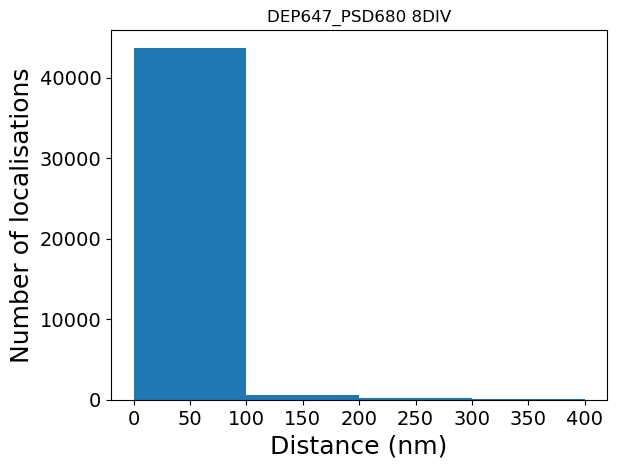

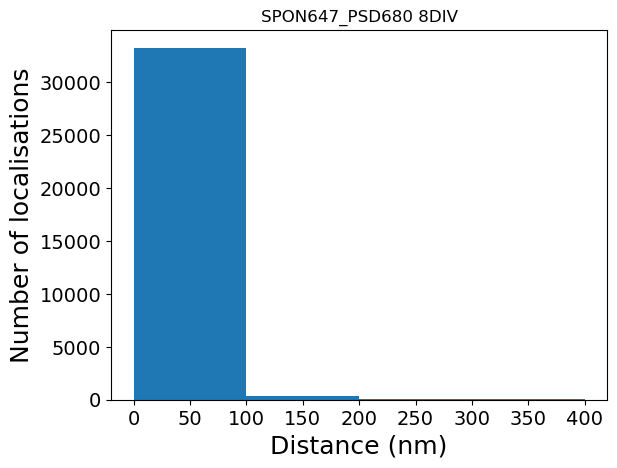

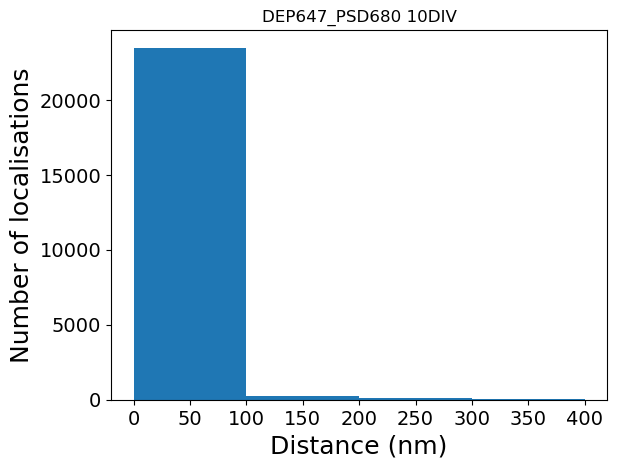

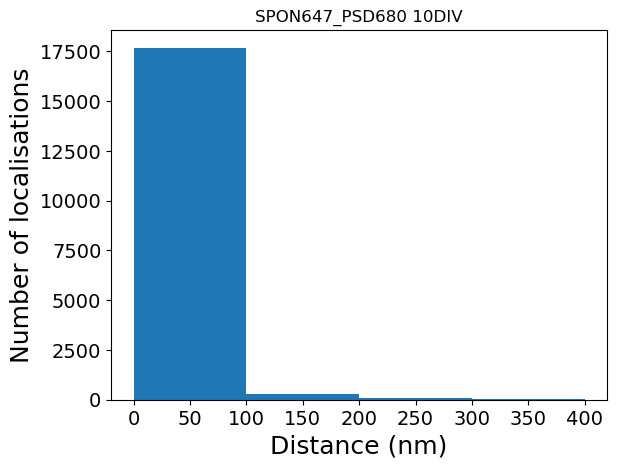

DEP647_PSD680 8DIV DescribeResult(nobs=44558, minmax=(68.0273972602663, 495.2469275365366), mean=70.80675386696294, variance=390.0659480161824, skewness=11.490245469046808, kurtosis=167.44378692706195)
SPON647_PSD680 8DIV DescribeResult(nobs=33756, minmax=(68.0273972602663, 481.0263390921097), mean=70.11891131078393, variance=291.3902957870131, skewness=12.325679110530535, kurtosis=188.43282259315887)
DEP647_PSD680 10DIV DescribeResult(nobs=23873, minmax=(68.0273972602663, 490.5525379165548), mean=70.40396728091787, variance=342.3171855523036, skewness=11.858714372680376, kurtosis=176.06957662657632)
SPON647_PSD680 10DIV DescribeResult(nobs=18064, minmax=(68.0273972602663, 490.5525379165528), mean=71.0736491270917, variance=426.56497920446867, skewness=10.577520944407146, kurtosis=141.35059700964467)


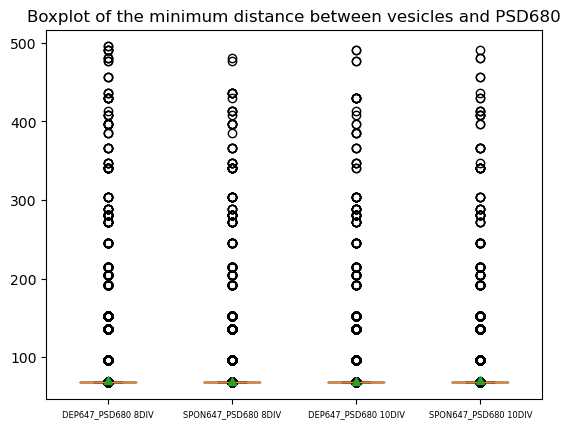

In [5]:
threshold=500
list_of_thresholds = list(range(0, threshold, 100))


data = min_dist_vesicle
keywords = ['SPON647_PSD680 8DIV', 'SPON647_PSD680 10DIV', 'DEP647_PSD680 8DIV', 'DEP647_PSD680 10DIV']

file_dic = fcts.sort_dict_by_keywords(data, keywords)

for i in range(0, len(list(file_dic.keys()))):
    file_dic[list(file_dic.keys())[i]] = file_dic[list(file_dic.keys())[i]][(file_dic[list(file_dic.keys())[i]]<threshold)]
    plt.title(list(file_dic.keys())[i])
    fcts.create_histogram(list_of_thresholds, file_dic[list(file_dic.keys())[i]])

plt.boxplot(list(file_dic.values()), showmeans=True, labels=list(file_dic.keys()))
plt.xticks(fontsize=6)
plt.title(f'Boxplot of the minimum distance between vesicles and {target_marker}')

for i in range(0, len(list(file_dic.keys()))):
    stats = sc.describe(file_dic[list(file_dic.keys())[i]])
    print(list(file_dic.keys())[i], stats)
    
#t_stat, p_value = sc.ttest_ind(file_dic['8DIV'], file_dic['10DIV'])
#print('t_stat:', t_stat, 'p-value:', p_value)

In [65]:
#permutation test

x = vesicle_type_nd_DIV['DEP647_PSD680 8DIV']
y = vesicle_type_nd_DIV['SPON647_PSD680 8DIV']


def statistic(x, y, axis):
    return np.mean(x, axis=axis) - np.mean(y, axis=axis)

from scipy.stats import permutation_test
# because our statistic is vectorized, we pass `vectorized=True`
# `n_resamples=np.inf` indicates that an exact test is to be performed
res = permutation_test((x, y), statistic, vectorized=True,
                       n_resamples=9999, alternative='less')
print(res.statistic)
print(res.pvalue)


KeyboardInterrupt: 

In [14]:
#trying DBScan
#define intensity threshold. Points which have a lower intensity will be excluded from the clustering.
int_threshold=0

#apply the threshold on the vesicle and synaptic marker datasets
vesicles_thresh = vesicles[vesicles[:,3]>int_threshold,0:3]
synapse_marker_thresh = synapse_marker[synapse_marker[:,3]>int_threshold, 0:3]

#compute the fraction of points including in the clustering.
frct_points_included = vesicles_thresh.shape[0]/vesicles.shape[0]*100
print('% points above threshold:', frct_points_included)

# Normalize the data to have zero mean and unit variance
data_norm = (vesicles_thresh - np.mean(vesicles_thresh, axis=0)) / np.std(vesicles_thresh, axis=0)

# Apply DBSCAN to the normalized data
dbscan = DBSCAN(eps=800, min_samples=150)
labels = dbscan.fit_predict(vesicles_thresh)

#compute the number of clusters rendered by DBSCAN
unique_labels = np.unique(labels[labels >= 0])
n_clusters = len(unique_labels)
print('number of clusters:', n_clusters)

plt.scatter(vesicles[:,0], vesicles[:,1], s=0.1, alpha=0.5)
for label in unique_labels:
    mask = labels == label
    if np.any(mask):
        plt.scatter(vesicles_thresh[mask, 0], vesicles_thresh[mask, 1], s=20)

plt.title("DBSCAN Clusters")
plt.legend()

# Show the plot
plt.show()
plt.tight_layout()

IndexError: index 3 is out of bounds for axis 1 with size 2

In [ ]:
#using a single file as example

ex_zone = ['/Volumes/STORM_Nathalie/STORM DeMixing/210414 DEP647_PSD680 8DIV/CellZone4/Demix/CoordTable_SAFE360_MULTIPLEXING_demixed_w1_UncertaintyFiltered.csv',
  '/Volumes/STORM_Nathalie/STORM DeMixing/210414 DEP647_PSD680 8DIV/CellZone4/Demix/CoordTable_SAFE360_MULTIPLEXING_demixed_w2_UncertaintyFiltered.csv']

ex_zone = list_of_files[0]

vesicles = pd.read_csv(ex_zone[0])[['x [nm]', 'y [nm]', 'z [nm]']].to_numpy(dtype=np.float64)
synapse_marker = pd.read_csv(ex_zone[1])[['x [nm]', 'y [nm]', 'z [nm]']].to_numpy(dtype=np.float64)

data=vesicles
image_size = (730,730,16)
kernel_size = (50,50,1)
sigma = 12

wide_field_image = fcts.get_wide_field(vesicles, image_size, kernel_size, sigma)

coords = np.array(coords)

plt.imshow(image[:,:,0])
plt.scatter(coords[:,1], coords[:,0], c='red')

In [106]:
def sort_dict_by_keywords(d, keywords):
    sorted_dict = {}
    for key in sorted(d.keys()):
        for kw in keywords:
            print(key)
            if kw in key:
                if kw in sorted_dict:
                    if type(d[key]) == float:
                        print(sorted_dict[kw])
                        print(d[key])
                        sorted_dict[kw] = np.append([sorted_dict[kw], d[key]])
                    else:
                        sorted_dict[kw] = np.concatenate([sorted_dict[kw], d[key]])
                        
                else:
                    if type(d[key]) == float:
                        sorted_dict[kw] = np.array([d[key]])
                    else:
                        sorted_dict[kw] = d[key]
    return sorted_dict

In [107]:
ex_dict = {'test1':12, 'test2':[3,4]}

In [108]:
sortexdict = sort_dict_by_keywords(SNR_dict, ['8', '10'])
sortexdict

210208 DEP647_PSD680 8DIV_CellZone1
210208 DEP647_PSD680 8DIV_CellZone1
210208 DEP647_PSD680 8DIV_CellZone2
[0.11283831]
0.05660817155605874


TypeError: _append_dispatcher() missing 1 required positional argument: 'values'

In [93]:
SNR_dict['210430 SPON647_PSD680 10DIV_CellZone6']

0.023819335696035605